In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries

In [1]:
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten, Activation, MaxPooling2D, Conv2D, Conv3D, Conv2DTranspose
# from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,ReduceLROnPlateau
from tensorflow import keras
tf.config.run_functions_eagerly(True)
from sklearn.utils.multiclass import type_of_target
from skimage.util import view_as_windows
from tensorflow.keras import initializers

In [2]:
import torch.backends.cudnn as cudnn
import torchvision
import glob
from google.colab.patches import cv2_imshow

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import stats
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

## Defocusing the image

In [4]:

def defocus_blur(image, blur_amount):
    output = cv2.GaussianBlur(image, (5, 5), blur_amount)
    return output

## Creating Dataset of original and defocused images


In [5]:
original_images = []
motion_blurred_images = []
defocus_blurred_images = []
for img in glob.glob("/content/drive/MyDrive/GT/*.png"):
  cv_img = cv2.imread(img)
  defocus_blurred = defocus_blur(cv_img, 5)
  
  #cv_img = cv_img.astype(np.float32) / 255.0
  original_images.append(cv_img)
  #defocus_blurred = defocus_blurred.astype(np.float32) / 255.0
  defocus_blurred_images.append(defocus_blurred)
  cv2.waitKey(0)
original_images = np.array(original_images)
motion_blurred_images = np.array(motion_blurred_images)
defocus_blurred_images = np.array(defocus_blurred_images)
type(original_images)

numpy.ndarray

## Creating patches for each image in defocused and original images set

In [6]:
# Define the shape of the patches
num_patches = 30
patch_height = 64
patch_width = 64
num_channels = 3
patch_stride = 32
print(original_images.shape)
patch_shape = (num_patches, patch_height, patch_width, num_channels)
# Make patches of the input array
patch_o = view_as_windows(original_images, patch_shape, step=patch_stride) 
patch_o = np.reshape(patch_o, (-1, patch_height, patch_width, num_channels))
print(patch_o.shape)

(30, 600, 800, 3)
(12240, 64, 64, 3)


In [7]:
# Define the shape of the patches
num_patches = 30
patch_height = 64
patch_width = 64
num_channels = 3
patch_stride = 32
print(original_images.shape)
patch_shape = (num_patches, patch_height, patch_width, num_channels)
# Make patches of the input array
patch_d= view_as_windows(defocus_blurred_images, patch_shape, step=patch_stride) 
patch_d = np.reshape(patch_d, (-1, patch_height, patch_width, num_channels))
print(patch_d.shape)

(30, 600, 800, 3)
(12240, 64, 64, 3)


## Defining DCNN Model

In [8]:
#initializer = tf.keras.initializers.Zeros()
model_DCNN = Sequential([    
Conv2D(38, activation='relu',input_shape =(184, 184, 3),  kernel_size = (121,1), padding = 'valid'),
Conv2D(38, activation='relu', kernel_size = (1, 121), padding = 'valid', groups=38),
Conv2D(3, activation='relu', kernel_size = (1, 1), padding = 'valid'),
])

model_DCNN_full = Sequential([
Conv2D(38, activation='relu',input_shape =(720, 920, 3),  kernel_size = (121,1), padding = 'valid'),
Conv2D(38, activation='relu', kernel_size = (1, 121), padding = 'valid', groups=38),
Conv2D(3, activation='relu', kernel_size = (1, 1), padding = 'valid'),
])
model_DCNN.compile(optimizer='adam',loss="mean_squared_error",#SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])

model_DCNN_full.compile(optimizer='adam',loss="mean_squared_error",#SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])

In [9]:
model_DCNN.summary()  
model_DCNN_full.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 184, 38)       13832     
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 38)        4636      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 3)         117       
                                                                 
Total params: 18,585
Trainable params: 18,585
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 600, 920, 38)      13832     
                                                                 
 conv2d_4 (Conv2D)           (

## Funtion to create padded images to feed to training model

In [10]:
def create_train_data(img):
  # img = img/255
  # img = img.astype('float16')
  r_x_train = np.pad(img[:, :,0 ],60, mode='constant')
  g_x_train= np.pad(img[:, :, 1],60, mode='constant')
  b_x_train = np.pad(img[:, :, 2],60, mode='constant')
  rgb_x_train = np.stack((r_x_train, g_x_train, b_x_train), axis = -1)
  return rgb_x_train

In [11]:
x_train=[]
for i in range(0,12240):
  rgb_x_train = create_train_data(patch_d[i,:,:,:])
  x_train.append(rgb_x_train)
x_train = np.array(x_train)
rgb_y_train = patch_o
print(x_train.shape)
print(rgb_y_train.shape)

(12240, 184, 184, 3)
(12240, 64, 64, 3)


In [12]:
# x_train=[]
# for i in range(0,12240):
#   r_x_train = np.pad(patch_d[i,:,:,0],60, mode='constant')
#   g_x_train= np.pad(patch_d[i,:,:,1],60, mode='constant')
#   b_x_train = np.pad(patch_d[i,:,:,2],60, mode='constant')
#   rgb_x_train = np.stack((r_x_train, g_x_train, b_x_train), axis = -1)
#   x_train.append(rgb_x_train)
# x_train = np.array(x_train)
# rgb_y_train = patch_o
# print(x_train.shape)
# print(rgb_y_train.shape)

In [13]:
# x_train = (x_train/255.0).astype('float16') 
# rgb_y_train = (rgb_y_train/255.0).astype('float16') 

In [13]:
history = model_DCNN.fit(x_train[:10000],rgb_y_train[:10000],epochs=15, validation_data = (x_train[10000:],rgb_y_train[10000:]))

Epoch 1/15
313/313 [==============================] - 22s 69ms/step - loss: 350.7010 - accuracy: 0.8359 - val_loss: 234.0237 - val_accuracy: 0.8766
Epoch 2/15
313/313 [==============================] - 21s 69ms/step - loss: 253.6635 - accuracy: 0.8578 - val_loss: 193.3298 - val_accuracy: 0.8936
Epoch 3/15
313/313 [==============================] - 22s 69ms/step - loss: 222.9815 - accuracy: 0.8701 - val_loss: 180.4016 - val_accuracy: 0.8990
Epoch 4/15
313/313 [==============================] - 21s 66ms/step - loss: 209.7587 - accuracy: 0.8764 - val_loss: 173.3097 - val_accuracy: 0.9075
Epoch 5/15
313/313 [==============================] - 22s 69ms/step - loss: 209.0990 - accuracy: 0.8771 - val_loss: 167.4262 - val_accuracy: 0.9029
Epoch 6/15
313/313 [==============================] - 21s 66ms/step - loss: 195.5422 - accuracy: 0.8839 - val_loss: 165.5549 - val_accuracy: 0.9142
Epoch 7/15
313/313 [==============================] - 22s 69ms/step - loss: 197.7242 - accuracy: 0.8798 - val_lo

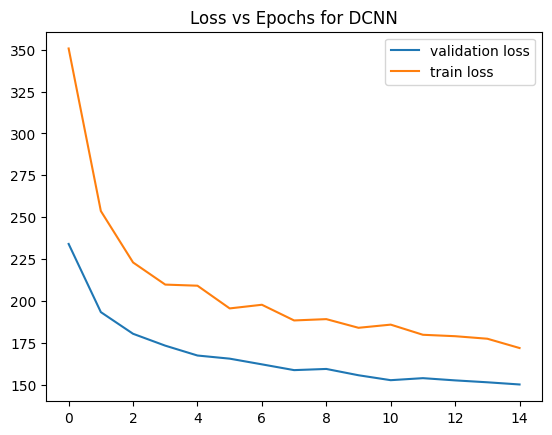

In [43]:
plt.title("Loss vs Epochs for DCNN")
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['loss'], label='train loss')
plt.legend()
plt.show()

### Transfering weights from trained model

In [15]:
model_DCNN_full.layers[0].set_weights(model_DCNN.layers[0].get_weights())
model_DCNN_full.layers[1].set_weights(model_DCNN.layers[1].get_weights())
model_DCNN_full.layers[2].set_weights(model_DCNN.layers[2].get_weights())

In [16]:
x_check=[]
for i in range(0,30):
  r_x_check = np.pad(defocus_blurred_images[i,:,:,0],60, mode='constant')
  g_x_check= np.pad(defocus_blurred_images[i,:,:,1],60, mode='constant')
  b_x_check = np.pad(defocus_blurred_images[i,:,:,2],60, mode='constant')
  rgb_x_check = np.stack((r_x_check, g_x_check, b_x_check), axis = -1)
  x_check.append(rgb_x_check)
x_check = np.array(x_check)
print(x_check.shape)

(30, 720, 920, 3)


## Test results with just DCNN model  
1st is original image  
2nd is blured image  
3rd is model output

1/1 [==============================] - 0s 59ms/step


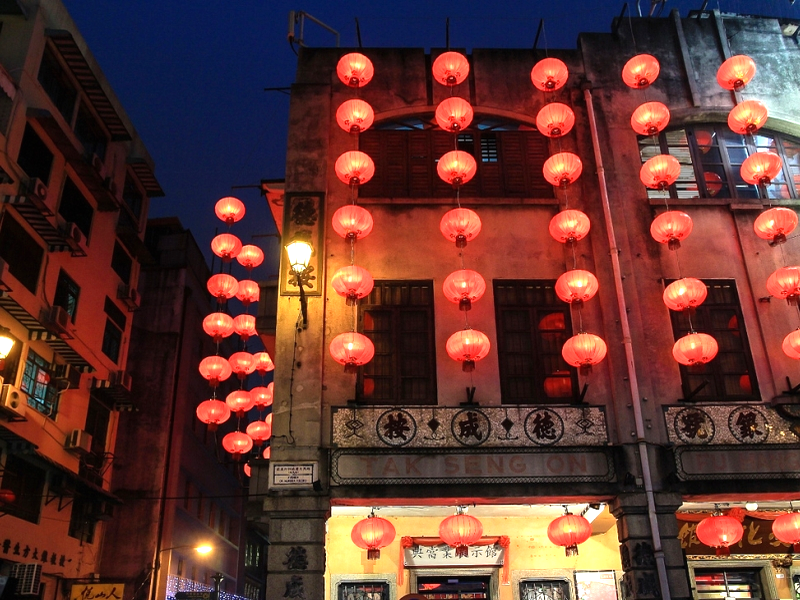

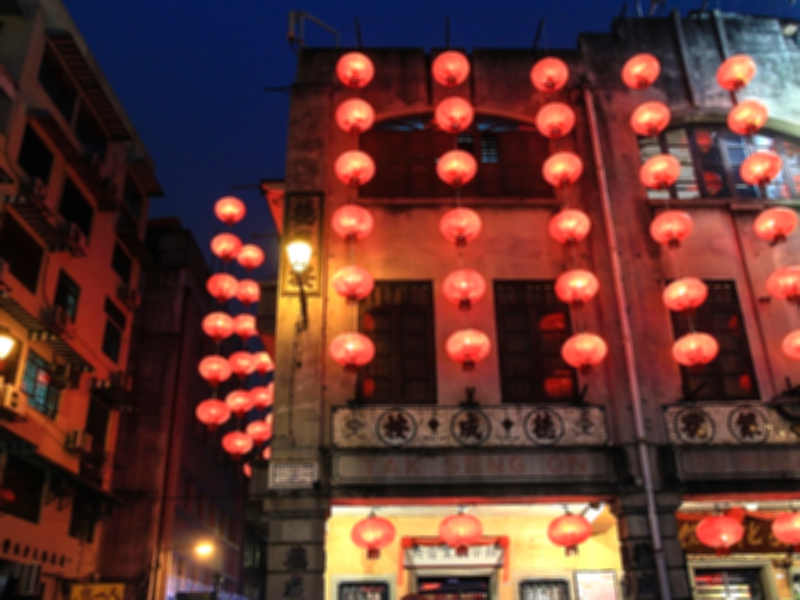

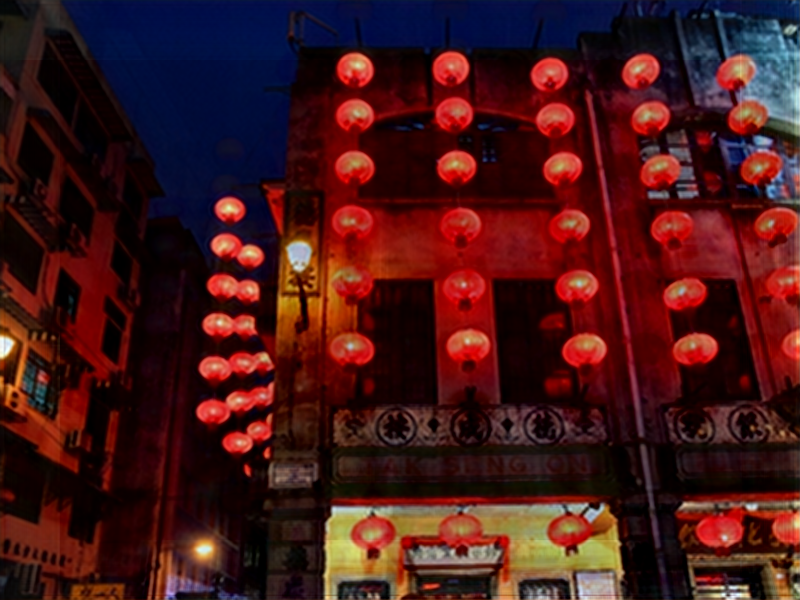

In [42]:
index = 24
x_check2 = x_check[index:index+1,:,:,:]
pred = model_DCNN_full.predict(x_check2)
cv2_imshow(original_images[index,:,:,:])              # original Image
cv2_imshow(defocus_blurred_images[index,:,:,:])       # Blurred image
cv2_imshow(pred[0,:,:,:])                             # Corrected image

The above image is not that good and has some noise, which will be removed by another model which is partially trained usnig the weights of this model

## Defining ODCNN model

In [21]:
model_Full_t = Sequential([
  Conv2D(38, activation='relu',input_shape =(192, 192, 3),  kernel_size = (121,1), padding = 'valid'),
  Conv2D(38, activation='relu', kernel_size = (1, 121), padding = 'valid', groups=38),
  Conv2D(512, activation='relu', kernel_size = (16,16), padding = 'valid'), 
  Conv2D(512, activation='relu', kernel_size = (1,1), padding = 'valid'), 
  Conv2DTranspose(3, activation='relu', kernel_size=(8,8), padding='valid')
])

model_Full = Sequential([
  Conv2D(38, activation='relu',input_shape =(728, 928, 3),  kernel_size = (121,1), padding = 'valid'),
  Conv2D(38, activation='relu', kernel_size = (1, 121), padding = 'valid', groups=38),
  Conv2D(512, activation='relu', kernel_size = (16,16), padding = 'valid'), 
  Conv2D(512, activation='relu', kernel_size = (1,1), padding = 'valid'), 
  Conv2DTranspose(3, activation='relu', kernel_size=(8,8), padding='valid')
])
model_Full_t.compile(optimizer='adam',loss="mean_squared_error",#SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
model_Full.compile(optimizer='adam',loss="mean_squared_error",#SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
model_Full.summary()
model_Full_t.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 608, 928, 38)      13832     
                                                                 
 conv2d_11 (Conv2D)          (None, 608, 808, 38)      4636      
                                                                 
 conv2d_12 (Conv2D)          (None, 593, 793, 512)     4981248   
                                                                 
 conv2d_13 (Conv2D)          (None, 593, 793, 512)     262656    
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 600, 800, 3)      98307     
 ranspose)                                                       
                                                                 
Total params: 5,360,679
Trainable params: 5,360,679
Non-trainable params: 0
____________________________________________

## Transfering weights from DCNN model

In [22]:
model_Full_t.layers[0].set_weights(model_DCNN.layers[0].get_weights())
model_Full_t.layers[1].set_weights(model_DCNN.layers[1].get_weights())

## Training ODCNN model with patches

In [23]:
x_train_f=[]
for i in range(0,12240):
  r_x_train_f = np.pad(patch_d[i,:,:,0],64, mode='constant')
  g_x_train_f = np.pad(patch_d[i,:,:,1],64, mode='constant')
  b_x_train_f = np.pad(patch_d[i,:,:,2],64, mode='constant')
  rgb_x_train_f = np.stack((r_x_train_f, g_x_train_f, b_x_train_f), axis = -1)
  x_train_f.append(rgb_x_train_f)
x_train_f = np.array(x_train_f)
rgb_y_train_f = patch_o
print(x_train_f.shape)
print(rgb_y_train_f.shape)

(12240, 192, 192, 3)
(12240, 64, 64, 3)


In [24]:
history_f = model_Full_t.fit(x_train_f[:10000],rgb_y_train_f[:10000],validation_data=(x_train_f[10000:],rgb_y_train_f[10000:]), epochs=20)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
313/313 [==============================] - 160s 461ms/step - loss: 44216.7852 - accuracy: 0.7104 - val_loss: 601.6968 - val_accuracy: 0.7755
Epoch 2/20
313/313 [==============================] - 138s 441ms/step - loss: 458.0663 - accuracy: 0.7799 - val_loss: 295.1664 - val_accuracy: 0.8406
Epoch 3/20
313/313 [==============================] - 133s 426ms/step - loss: 352.8624 - accuracy: 0.7912 - val_loss: 247.2548 - val_accuracy: 0.8424
Epoch 4/20
313/313 [==============================] - 134s 427ms/step - loss: 270.3905 - accuracy: 0.8085 - val_loss: 231.9788 - val_accuracy: 0.8389
Epoch 5/20
313/313 [==============================] - 134s 427ms/step - loss: 259.1122 - accuracy: 0.8186 - val_loss: 189.3858 - val_accuracy: 0.8519
Epoch 6/20
313/313 [==============================] - 134s 428ms/step - loss: 229.7527 - accuracy: 0.8293 - val_loss: 170.7628 - val_accuracy: 0.8531
Epoch 7/20
313/313 [==============================] - 139s 445ms/step - loss: 202.8968 - accuracy:

## Creating testing data for ODCNN model

In [25]:
x_check_f=[]
for i in range(0,30):
  r_x_check_f = np.pad(defocus_blurred_images[i,:,:,0],64, mode='constant')
  g_x_check_f = np.pad(defocus_blurred_images[i,:,:,1],64, mode='constant')
  b_x_check_f = np.pad(defocus_blurred_images[i,:,:,2],64, mode='constant')
  rgb_x_check_f = np.stack((r_x_check_f, g_x_check_f, b_x_check_f), axis = -1)
  x_check_f.append(rgb_x_check_f)
x_check_f = np.array(x_check_f)
print(x_check_f.shape)

(30, 728, 928, 3)


## Transferring weights from trained ODCNN model

In [26]:
model_Full.layers[0].set_weights(model_Full_t.layers[0].get_weights())
model_Full.layers[1].set_weights(model_Full_t.layers[1].get_weights())
model_Full.layers[2].set_weights(model_Full_t.layers[2].get_weights())
model_Full.layers[3].set_weights(model_Full_t.layers[3].get_weights())
model_Full.layers[4].set_weights(model_Full_t.layers[4].get_weights())

## Test result of ODCNN model  
1st is original image  
2nd is blurred image  
3rd is model output

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 413ms/step


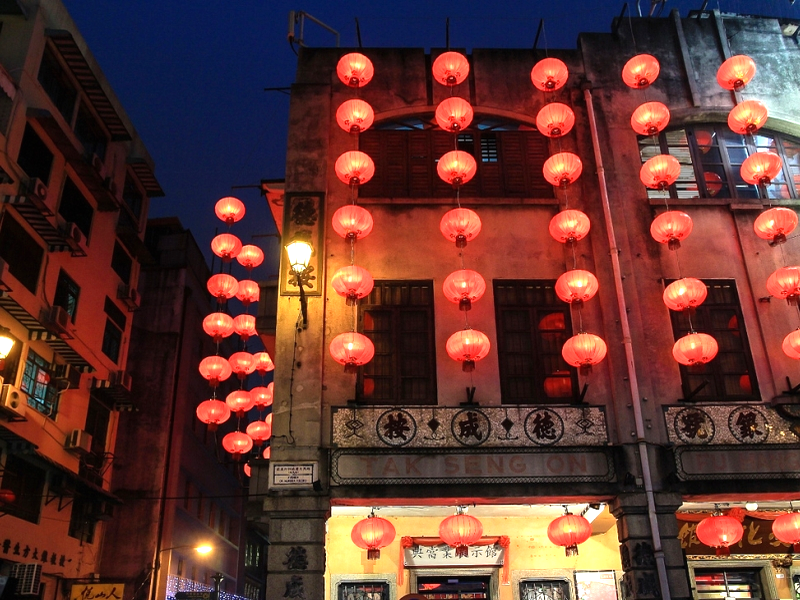

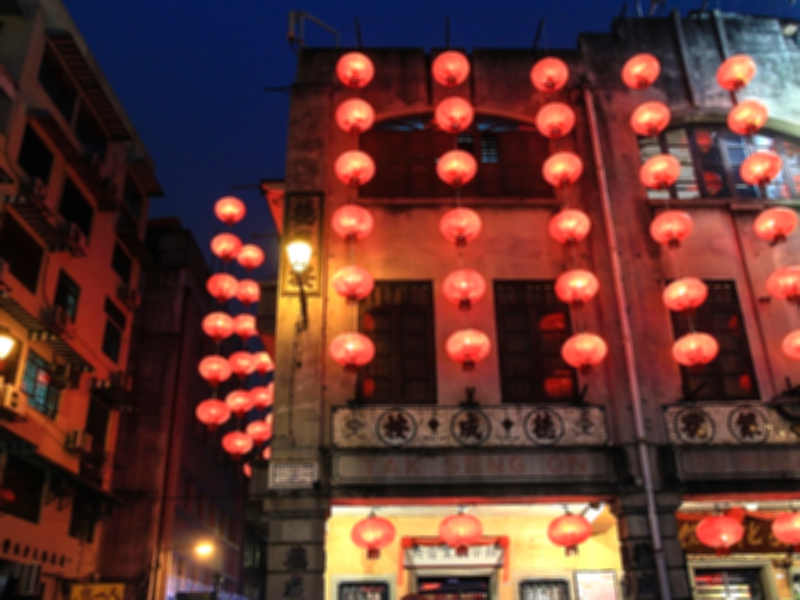

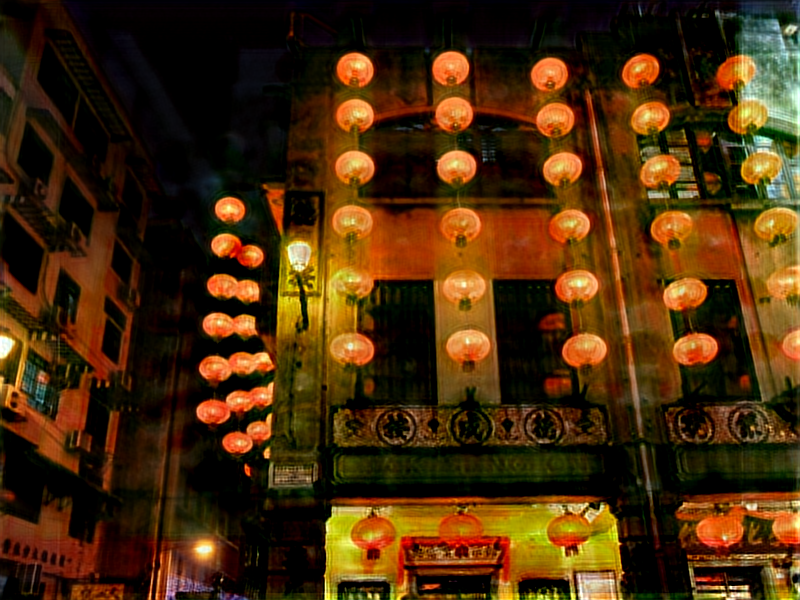

In [38]:
index = 24
x_check2 = x_check_f[index:index+1,:,:,:]
pred_f = model_Full.predict(x_check2)
cv2_imshow(original_images[index,:,:,:])              # Original Image
cv2_imshow(defocus_blurred_images[index,:,:,:])       # Blurred images
cv2_imshow(pred_f[0,:,:,:])                           # Model output

## Comparision between DCNN and ODCNN model outputs  
1st is DCNN output  
2nd is ODCNN output

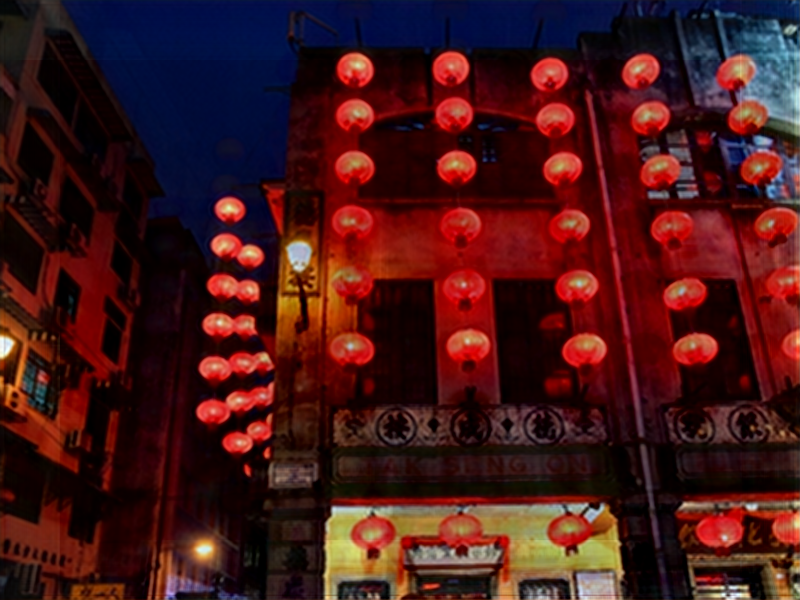

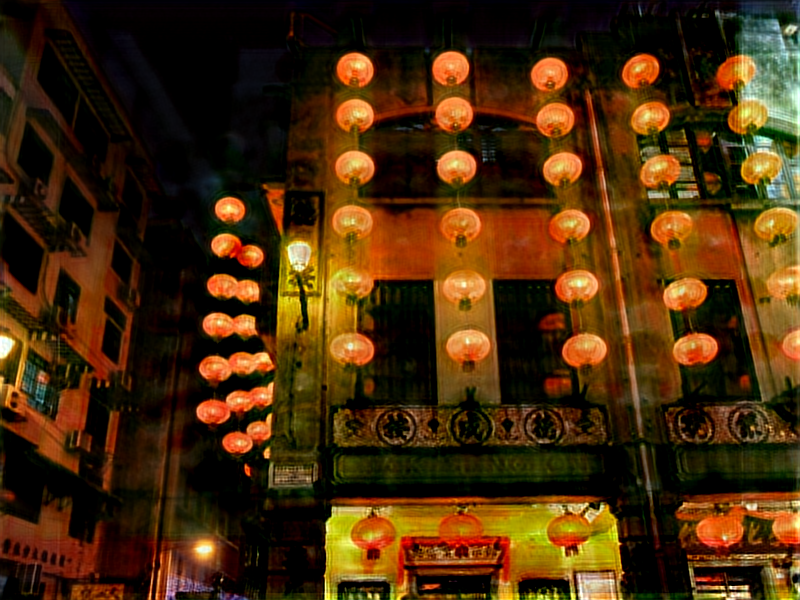

In [47]:
cv2_imshow(pred[0,:,:,:]) 
cv2_imshow(pred_f[0,:,:,:])    

In the above image it can be observed that overall sharpness is better in ODCNN, also in the left the buildings are more chrisp in ODCNN image.
ODCNN further enhances the image that is outputed from the DCNN model